First I am going to do linear analysis on the data to see if I can predict traffic based on hour

In [2]:
import pandas as pd

df = pd.read_csv('traffic_weather.csv')
print(df.columns)
print(len(df))

Index(['Intersection Name', 'Month', 'Day', 'Year', 'Hour', 'Day of Week',
       'Holiday', 'Direction', 'Speed', 'Volume', 'Full Date', 'date', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'temperature'],
      dtype='object')
229939


In [3]:
print(df['Day of Week'].max())
print(df['Day of Week'].min())


6
0


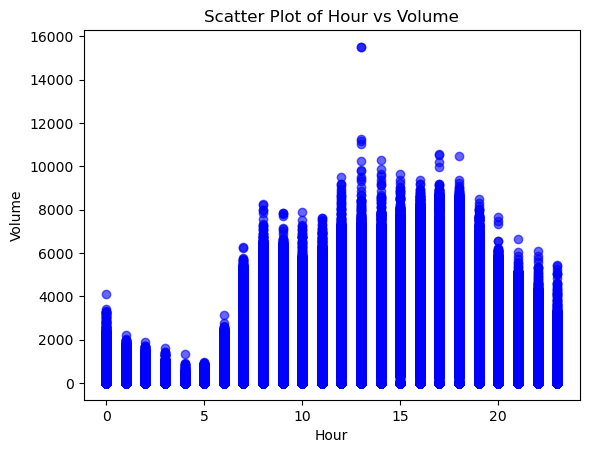

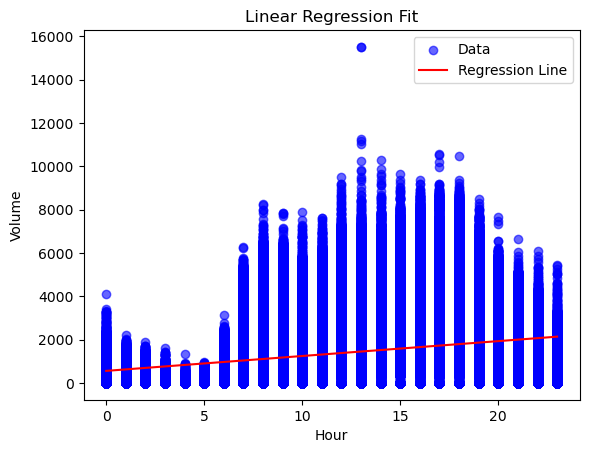

R-squared: 0.09
Mean Squared Error: 2330401.92


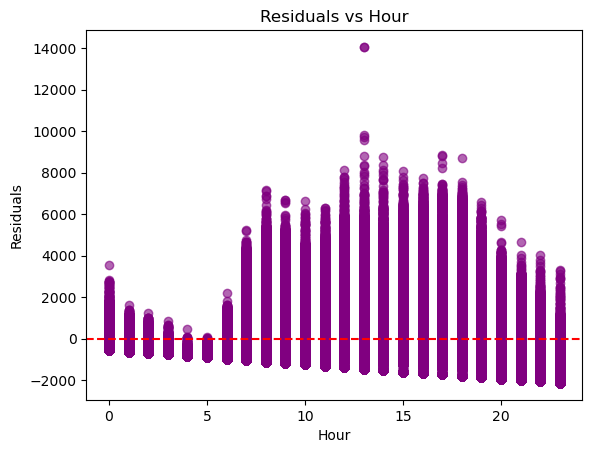

In [7]:
## Create a linear model predicting volume from hour and check for linearity 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset
# df = pd.read_csv('your_file.csv')

# Ensure no missing values
df = df.dropna(subset=['Hour', 'Volume'])

# Visualize the data
plt.scatter(df['Hour'], df['Volume'], color='blue', alpha=0.6)
plt.title('Scatter Plot of Hour vs Volume')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.show()

# Prepare data for modeling
X = df[['Hour']].values  # Feature matrix
y = df['Volume'].values  # Target variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Visualize the regression line
plt.scatter(df['Hour'], df['Volume'], color='blue', alpha=0.6, label='Data')
plt.plot(df['Hour'], y_pred, color='red', label='Regression Line')
plt.title('Linear Regression Fit')
plt.xlabel('Hour')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Evaluate the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Check residuals
residuals = y - y_pred
plt.scatter(df['Hour'], residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residuals')
plt.show()


## Results of checking for linearity 

The relationship between volume and hour is not linear in its current form. The residuals are not normally distrobuted and the model does not do a good job of predicting volume.  Rather, it looks like there is an element of seasonality. 

To examine the seasonlity effect, the next model will introduce a lag volume variable to see if that increases the models predictaability. 

In [50]:
import pandas as pd

# Example dataset
# Ensure your DataFrame has the necessary columns
# df = pd.read_csv('your_file.csv')

# Convert to datetime if not already
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.sort_values(by=['Date', 'Hour'])

# Group by Date and shift the Volume
df['Lag_Volume'] = df.groupby(['Year', 'Month', 'Day'])['Volume'].shift(1)

# Optional: Handle missing values (e.g., fill with 0 or drop them)
df['Lag_Volume'] = df['Lag_Volume'].fillna(0)  # Or use df.dropna(subset=['Lag_Volume'])

# View the updated DataFrame
print(df.head())


       Road Name  Month  Day  Year  Hour  Day of Week  Holiday Direction  \
61918     BURNET      6   18  2017     0            0        1        NB   
61919     BURNET      6   18  2017     0            0        1        SB   
123838  CONGRESS      6   18  2017     0            0        1        NB   
123839  CONGRESS      6   18  2017     0            0        1        SB   
185758     LAMAR      6   18  2017     0            0        1        NB   

        Speed  Volume            Full Date       Date  Lag_Volume  
61918     NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
61919     NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
123838    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
123839    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  
185758    NaN     0.0  2017-06-18 00:00:00 2017-06-18         0.0  


R-squared: 0.52
Mean Squared Error: 1249514.59


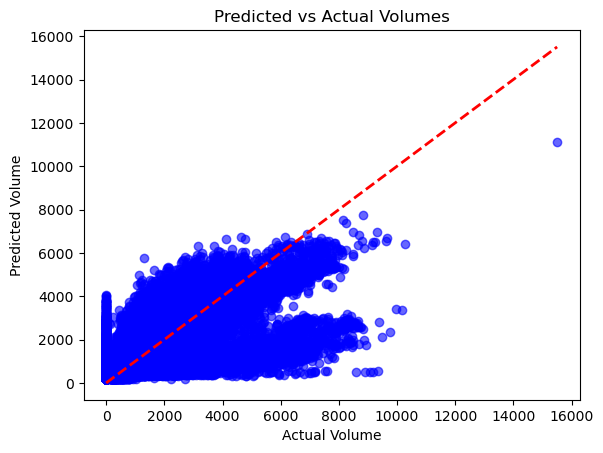

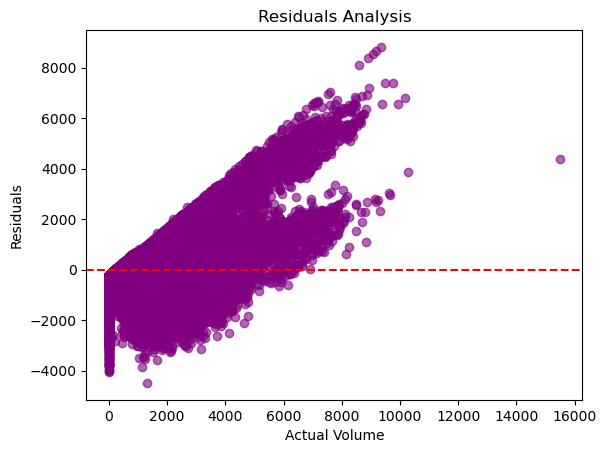

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Ensure 'Lag_Volume' is created
df['Lag_Volume'] = df.groupby(['Year', 'Month', 'Day'])['Volume'].shift(1)
df = df.dropna(subset=['Lag_Volume'])  # Drop rows with missing Lag_Volume

# Define features (X) and target (y)
X = df[['Hour', 'Lag_Volume']]  # Add other features if necessary
y = df['Volume']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

# Visualize predictions vs actual values
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Volumes')
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.show()

# Analyze Residuals
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Analysis')
plt.xlabel('Actual Volume')
plt.ylabel('Residuals')
plt.show()


## Lag Model Results

This model greatly increases the predictive performance of the model from 2% to 50%. However, the model still does not experince a linear relationship even with this new variable. 


# Neural Network for Volume Prediction

This code implements a neural network using PyTorch to predict vehicle volume based on traffic and temporal features. The process includes:

1. **Preprocessing**: Ensuring that all feature columns are numeric and splitting the data into training and testing sets.
2. **Model Architecture**: A configurable neural network with dynamic hidden layers and nodes, allowing flexibility in experimentation.
3. **Training**: Using Mean Squared Error (MSE) loss and Stochastic Gradient Descent (SGD) optimizer to minimize the prediction error.
4. **Evaluation**: Calculating Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for model accuracy.

## Results:
- Training and test losses are logged over epochs to monitor convergence.
- Final accuracy metrics (MAE and RMSE) provide insights into prediction performance.
- Loss curves are visualized for further analysis of model training dynamics.


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Assume df_copy2 is your original dataframe
df_copy2 = df.copy()

# Fill missing speed values with average speed for the corresponding hour (before dropping 'Hour')
df_copy2['Speed'] = df_copy2.groupby('Hour')['Speed'].transform(lambda x: x.fillna(x.mean()))

# Cyclical encoding for 'Month'
df_copy2['Month_sin'] = np.sin(2 * np.pi * df_copy2['Month'] / 12)
df_copy2['Month_cos'] = np.cos(2 * np.pi * df_copy2['Month'] / 12)

# Cyclical encoding for 'Day'
df_copy2['Day_sin'] = np.sin(2 * np.pi * df_copy2['Day'] / 31)
df_copy2['Day_cos'] = np.cos(2 * np.pi * df_copy2['Day'] / 31)

# Cyclical encoding for 'Hour'
df_copy2['Hour_sin'] = np.sin(2 * np.pi * df_copy2['Hour'] / 24)
df_copy2['Hour_cos'] = np.cos(2 * np.pi * df_copy2['Hour'] / 24)

# Cyclical encoding for 'Day of Week'
df_copy2['DayOfWeek_sin'] = np.sin(2 * np.pi * df_copy2['Day of Week'] / 7)
df_copy2['DayOfWeek_cos'] = np.cos(2 * np.pi * df_copy2['Day of Week'] / 7)

# Drop the original columns now that we have the cyclical features
df_copy2 = df_copy2.drop(columns=['Month', 'Day', 'Hour', 'Day of Week'])

# Handle missing values in numerical columns
numerical_cols = ['Speed', 'temperature', 'prcp', 'snow', 'wspd', 'Year']
df_copy2[numerical_cols] = df_copy2[numerical_cols].fillna(df_copy2[numerical_cols].mean())  # Impute with mean

# Handle missing values in categorical columns by filling with a placeholder value ('Unknown')
categorical_cols = ['Intersection Name', 'Direction']
df_copy2[categorical_cols] = df_copy2[categorical_cols].fillna('Unknown')  # Impute with 'Unknown'

# One-hot encode categorical columns (e.g., 'Intersection Name' and 'Direction')
encoder = ColumnTransformer(
    transformers=[
        ('road_name', OneHotEncoder(drop='first'), ['Intersection Name']),
        ('direction', OneHotEncoder(drop='first'), ['Direction'])
    ],
    remainder='passthrough'
)

# Apply encoding and transform the data
encoded_data = encoder.fit_transform(df_copy2)

# Convert to dataframe
df_copy2 = pd.DataFrame(
    encoded_data,
    columns=(encoder.named_transformers_['road_name'].get_feature_names_out(['Intersection Name']).tolist() +
             encoder.named_transformers_['direction'].get_feature_names_out(['Direction']).tolist() +
             df_copy2.drop(columns=['Intersection Name', 'Direction']).columns.tolist())
)

# Drop irrelevant columns
df_copy2.drop(columns=['Full Date', 'date', 'tmin', 'tmax', 'tavg'], inplace=True)

# Handle any remaining missing values (if there are any after encoding)
df_copy2 = df_copy2.fillna(df_copy2.mean())  # Impute missing numerical columns with the mean

# Standardize numerical columns
scaler = StandardScaler()
numerical_cols = ['Speed', 'temperature', 'prcp', 'snow', 'wspd', 'Year']
df_copy2[numerical_cols] = scaler.fit_transform(df_copy2[numerical_cols])

# Separate features and target variable
X = df_copy2.drop('Volume', axis=1)
y = df_copy2['Volume']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the final processed data and ensure no missing values remain
print("Data preprocessing complete!")


Data preprocessing complete!


In [26]:
# Build the network two dense layers, one dropout layer, one output

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def create_model(optimizer='adam', dropout_rate=0.02):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense (32, activation='relu'))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=optimizer, loss=rmse, metrics=['mae'])
    return model


Epoch [10], Training Loss: 384305.3750, Test Loss: 387174.6562
Epoch [20], Training Loss: 384202.5000, Test Loss: 387071.2812
Epoch [30], Training Loss: 384098.1875, Test Loss: 386966.4688
Epoch [40], Training Loss: 383992.1250, Test Loss: 386859.8438
Epoch [50], Training Loss: 383884.0625, Test Loss: 386751.0938
Epoch [60], Training Loss: 383773.4375, Test Loss: 386639.8438
Epoch [70], Training Loss: 383659.9375, Test Loss: 386525.5625
Epoch [80], Training Loss: 383543.0938, Test Loss: 386407.9688
Epoch [90], Training Loss: 383422.3438, Test Loss: 386286.3438
Epoch [100], Training Loss: 383297.2188, Test Loss: 386160.2812
Epoch [110], Training Loss: 383167.0938, Test Loss: 386029.1250
Epoch [120], Training Loss: 383031.3750, Test Loss: 385892.3125
Epoch [130], Training Loss: 382889.5625, Test Loss: 385749.2812
Epoch [140], Training Loss: 382740.8125, Test Loss: 385599.2812
Epoch [150], Training Loss: 382584.5938, Test Loss: 385441.6875
Epoch [160], Training Loss: 382420.1562, Test Los

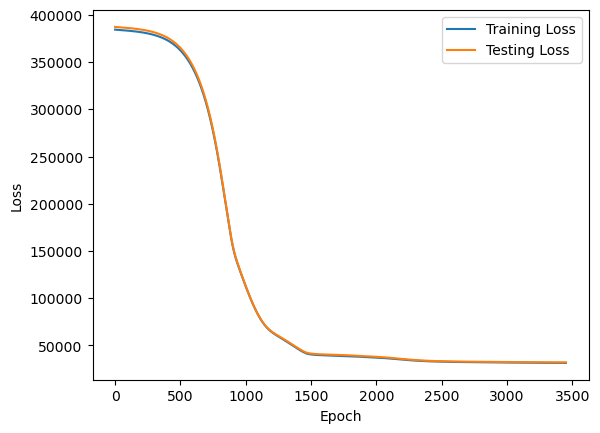

Mean Absolute Error (MAE): 121.0478
Root Mean Squared Error (RMSE): 178.9583


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Set neural network architecture parameters
set_hidden_layers = 6  # Number of hidden layers
set_hidden_nodes = 8   # Number of nodes in each hidden layer
lr = 0.01              # Learning rate

# Ensure all columns are numeric (after encoding)
df_copy2 = df_copy2.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric
X = df_copy2.drop(columns=['Volume']).select_dtypes(include=[np.number]).values  # Features
y = df_copy2['Volume'].values  # Target variable (Volume)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define a neural network class with dynamic hidden layers
class VolumePredictor(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_nodes):
        super(VolumePredictor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_nodes))  # Input layer
        layers.append(nn.ReLU())  # Activation function
        
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))  # Hidden layers
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_nodes, 1))  # Output layer
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = VolumePredictor(input_size, set_hidden_layers, set_hidden_nodes)

# Define loss function (MSE) and optimizer (SGD)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr)

# Training parameters
tolerance = 1e-5  # Convergence tolerance
prev_loss = float('inf')
epoch = 0
train_loss_values = []  # List to store training loss over epochs
test_loss_values = []   # List to store testing loss over epochs

# Training loop
while True:
    model.train()
    predictions = model(X_train_tensor)  # Forward pass
    loss = criterion(predictions, y_train_tensor)  # Compute training loss
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()  # Update weights

    train_loss_values.append(loss.item())  # Record training loss
    loss_change = prev_loss - loss.item()
    epoch += 1
    prev_loss = loss.item()

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
        test_loss_values.append(test_loss.item())

    if loss_change < tolerance:  # Check for convergence
        print(f"Convergence reached at epoch {epoch} with loss change of {loss_change:.6f}")
        break

    if epoch % 10 == 0:  # Print progress every 10 epochs
        print(f'Epoch [{epoch}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Ensure test loss matches train loss in length for plotting
while len(test_loss_values) < len(train_loss_values):
    test_loss_values.append(test_loss_values[-1])

# Plot training and testing loss
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model accuracy with MAE and RMSE
y_test_pred = test_predictions.numpy()
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


In [28]:
# Evaluate model accuracy on the training and test sets
model.eval()

with torch.no_grad():
    # Predictions for training and test sets
    y_train_pred = model(X_train_tensor).numpy()
    y_test_pred = model(X_test_tensor).numpy()

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = 1 - (np.sum((y_train - y_train_pred.flatten())**2) / np.sum((y_train - np.mean(y_train))**2))

# Calculate metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = 1 - (np.sum((y_test - y_test_pred.flatten())**2) / np.sum((y_test - np.mean(y_test))**2))

# Print accuracy metrics
print("Training Set Metrics:")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"  R² Score: {train_r2:.4f}")

print("Test Set Metrics:")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"  R² Score: {test_r2:.4f}")

# Calculate MAPE for training set
train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
train_accuracy = 100 - train_mape  # Convert MAPE to percent accuracy

# Calculate MAPE for test set
test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100
test_accuracy = 100 - test_mape  # Convert MAPE to percent accuracy

# Print percent accuracy for training and test sets
print("Training Set Percent Accuracy: {:.2f}%".format(train_accuracy))
print("Test Set Percent Accuracy: {:.2f}%".format(test_accuracy))



Training Set Metrics:
  Mean Absolute Error (MAE): 120.1228
  Root Mean Squared Error (RMSE): 177.4017
  R² Score: 0.7979
Test Set Metrics:
  Mean Absolute Error (MAE): 121.0478
  Root Mean Squared Error (RMSE): 178.9583
  R² Score: 0.7959
Training Set Percent Accuracy: -inf%
Test Set Percent Accuracy: -inf%


/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_34629/4026807549.py:31: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((y_train - y_train_pred.flatten()) / y_train)) * 100
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_34629/4026807549.py:35: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((y_test - y_test_pred.flatten()) / y_test)) * 100


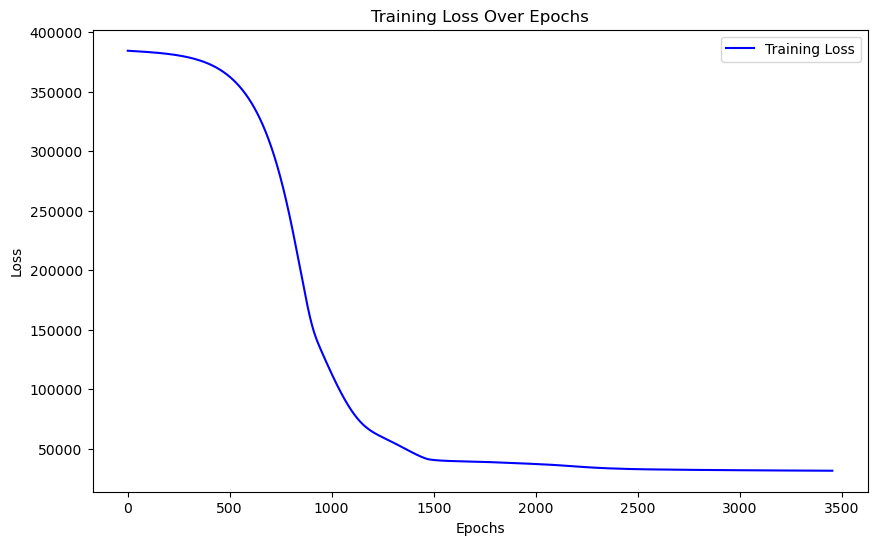

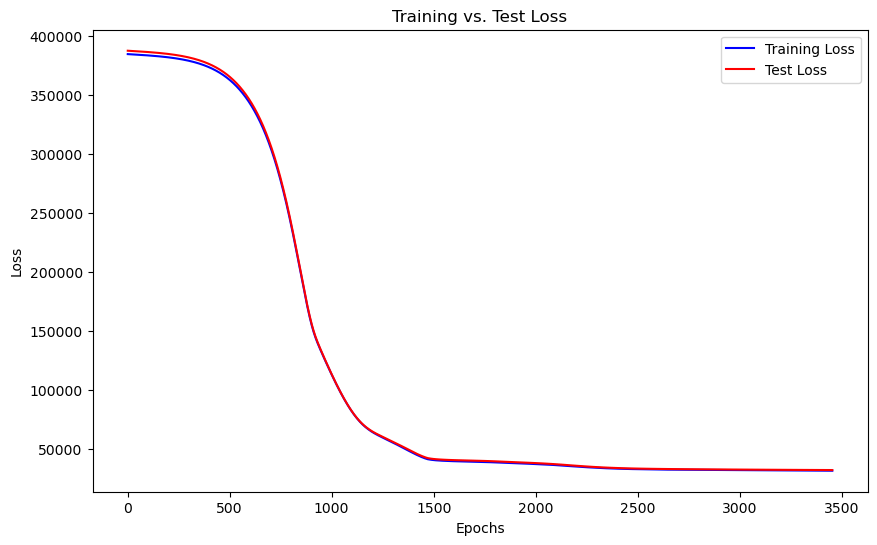

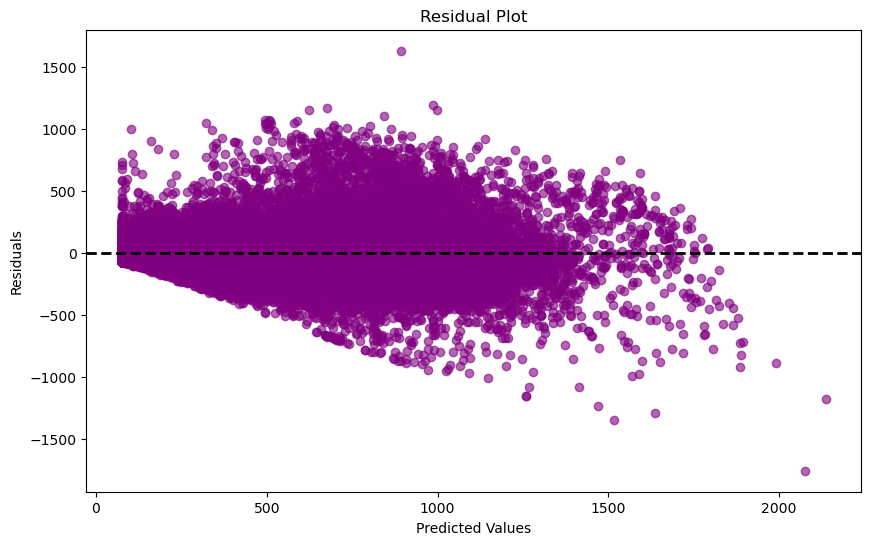

In [29]:
# 1. Plotting the Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# 2. Training vs. Test Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training Loss', color='blue')
plt.plot(range(1, len(test_loss_values) + 1), test_loss_values, label='Test Loss', color='red')  # Track test losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.show()

# 3. Residual Plot
# Generate predictions on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Ensure predictions and y_test_tensor have the same shape
predictions = predictions.squeeze()
y_test_tensor = y_test_tensor.squeeze()

# Calculate residuals
residuals = y_test_tensor - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6, color='purple')
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


## Better attempt at NN

I am using the homeworks to base this next NN off of rather than just guess as above. Seeing if I can bet a better predictive accuracy than above. 

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset

# Copy the dataframe to preserve the original
df_copy3 = df.copy()

# Drop 'Full Date' and other irrelevant columns
df_copy3 = df_copy3.drop(columns=['Full Date', 'date', 'tmin', 'tmax', 'tavg'])

# Handle missing values in 'Speed' (use hourly average)
hourly_avg_speed = df_copy3.groupby('Hour')['Speed'].transform('mean')
df_copy3['Speed'] = df_copy3['Speed'].fillna(hourly_avg_speed)

# Handle missing values in other columns
numerical_cols = ['Speed', 'temperature', 'prcp', 'snow', 'wspd', 'Year']
df_copy3[numerical_cols] = df_copy3[numerical_cols].fillna(df_copy3[numerical_cols].mean())  # Impute with mean

categorical_cols = ['Intersection Name', 'Direction']
df_copy3[categorical_cols] = df_copy3[categorical_cols].fillna('Unknown')  # Impute categorical with 'Unknown'

# One-hot encode categorical columns
df_copy3 = pd.get_dummies(df_copy3, columns=categorical_cols, drop_first=True)

# Standardize numerical columns
scaler = StandardScaler()
df_copy3[numerical_cols] = scaler.fit_transform(df_copy3[numerical_cols])

# Separate features and target variable
X = df_copy3.drop(columns=['Volume'])
y = df_copy3['Volume']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Check data types before conversion to tensor
print(X_train.dtypes)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Check if data preprocessing is complete
print("Data preprocessing complete!")


Month                                         int64
Day                                           int64
Year                                        float64
Hour                                          int64
Day of Week                                   int64
Holiday                                       int64
Speed                                       float64
prcp                                        float64
snow                                        float64
wspd                                        float64
temperature                                 float64
Intersection Name_BURNETPALM WAY              uint8
Intersection Name_BurnetRutland               uint8
Intersection Name_CONGRESSBARTON SPRINGS      uint8
Intersection Name_CongressJohanna             uint8
Intersection Name_LAMARCOLLIER                uint8
Direction_SB                                  uint8
dtype: object
Data preprocessing complete!


In [13]:
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, nonlin, num_classes=1):
        super(MyModule, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inp_size, hidden_sizes[0]),
            nonlin,
            *[
                layer
                for i in range(len(hidden_sizes) - 1)
                for layer in (
                    nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]),
                    nonlin,
                )
            ],
            nn.Linear(hidden_sizes[-1], num_classes)  # Adjust output layer
        )
    def forward(self, x):
        return self.layers(x)


In [14]:
def train(model, X_train, y_train, X_valid, y_valid, n_epochs, batch_size, optimizer, loss_fn):
    import torch
    from torch.utils.data import DataLoader, TensorDataset

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize variables to track best model
    best_weights = None
    best_mse = float('inf')
    train_history = []
    valid_history = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_valid_tensor)
            val_loss = loss_fn(val_predictions, y_valid_tensor).item()

        # Track the best model weights
        if val_loss < best_mse:
            best_mse = val_loss
            best_weights = model.state_dict()

        train_history.append(epoch_loss / len(train_loader))
        valid_history.append(val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{n_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return best_weights, train_history, valid_history, best_mse


In [21]:
# Evaluate Function

import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
import numpy as np

def eval(model, X, y):
    model.eval()
    # Convert inputs to numpy arrays and then to tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)  # Convert DataFrame to numpy and then tensor
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Convert to tensor
    
    with torch.no_grad():
        y_pred = model(X_tensor)
        mse = F.mse_loss(y_pred, y_tensor).item()
        rmse = np.sqrt(mse)  # Calculate RMSE from MSE
        r2 = r2_score(y, y_pred.numpy())  # Convert predictions to numpy for sklearn
    
    return mse, rmse, r2

    return mse, r2, rmse



In [20]:
from sklearn.model_selection import ParameterGrid
import copy

# Define parameter grid
param_grid = {
    'inp_size': [X_train.shape[1]],  # Number of features after preprocessing
    'hidden_sizes': [[16, 8], [32, 16, 8]],
    'lr': [0.001, 0.01],
    'n_epochs': [10, 20],
    'batch_size': [64, 128]
}

best_model = None
best_weights = None
best_mse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Initialize model (assuming a custom model class 'MyModule' is defined elsewhere)
    model = MyModule(
        inp_size=params['inp_size'],
        hidden_sizes=params['hidden_sizes'],
        nonlin=nn.ReLU()
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.MSELoss()

    # Train the model and get results
    current_weights, train_history, valid_history, current_mse = train(
        model, 
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        params['n_epochs'], 
        params['batch_size'], 
        optimizer, 
        loss_fn
    )

    # Check if this model is the best so far
    if current_mse < best_mse:
        best_mse = current_mse
        best_model = copy.deepcopy(model)  # Save the entire model
        best_weights = copy.deepcopy(current_weights)  # Save the best weights
        best_params = params  # Save the best hyperparameters

print(f"Best MSE: {best_mse}")
print(f"Best Params: {best_params}")


Epoch [1/10], Training Loss: 343695657.6094, Validation Loss: 98455.6250
Epoch [2/10], Training Loss: 207533933.9375, Validation Loss: 70107.8516
Epoch [3/10], Training Loss: 161187500.6895, Validation Loss: 61272.4844
Epoch [4/10], Training Loss: 148556639.7344, Validation Loss: 57902.4258
Epoch [5/10], Training Loss: 141628886.2598, Validation Loss: 55503.2773
Epoch [6/10], Training Loss: 135667791.6602, Validation Loss: 53346.2617
Epoch [7/10], Training Loss: 130643941.0391, Validation Loss: 51589.1836
Epoch [8/10], Training Loss: 126531469.3105, Validation Loss: 49954.0820
Epoch [9/10], Training Loss: 122627838.7061, Validation Loss: 48784.6719
Epoch [10/10], Training Loss: 119508181.4277, Validation Loss: 47694.2812
Epoch [1/20], Training Loss: 370929986.0352, Validation Loss: 109771.9219
Epoch [2/20], Training Loss: 257056506.8398, Validation Loss: 94517.3281
Epoch [3/20], Training Loss: 206301268.0000, Validation Loss: 68422.8438
Epoch [4/20], Training Loss: 152532240.1465, Vali

In [22]:
# Evaluate on test set
test_mse, test_rmse, test_r2 = eval(best_model, X_test, y_test)

# Print the results
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")



Test MSE: 12055.861328125
Test RMSE: 109.79918637278239
Test R2: 0.9226527006394571


## Tensor Flow NN

This model was built using the direct weather_traffic dataset not updated.

In [10]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np


In [17]:
# Group by 'Hour' and compute the mean for the 'Speed' column
hourly_avg_speed = df.groupby('Hour')['Speed'].transform('mean')

# Replace NaN values in 'Speed' with the corresponding hourly average
df['Speed'] = df['Speed'].fillna(hourly_avg_speed)

# Drop irrelevant columns
df_copy = df.drop(['Full Date', 'date', 'tmin', 'tmax', 'tavg'], axis=1)

# Drop rows with NaN values in any column
df_copy = df_copy.dropna()

# One-hot encode categorical columns
df_copy = pd.get_dummies(df_copy, columns=['Intersection Name', 'Direction'], drop_first=True)

# Normalize numerical columns (use the cleaned `df_copy`)
scaler = StandardScaler()
numerical_cols = ['Speed', 'temperature', 'prcp', 'snow', 'wspd']
df_copy[numerical_cols] = scaler.fit_transform(df_copy[numerical_cols])

# Separate features and target variable
X = df_copy.drop('Volume', axis=1)
y = df_copy['Volume']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Data processing complete!")


Data processing complete!


In [12]:
# Option to Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Build the network two dense layers, one dropout layer, one output

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def create_model(optimizer='adam', dropout_rate=0.02):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense (32, activation='relu'))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=optimizer, loss=rmse, metrics=['mae'])
    return model


In [14]:
# Train the model
model = create_model()

# Define RMSE loss function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # This will still monitor the validation loss
    patience=7,           # Number of epochs to wait after last improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)

# Define the model architecture with RMSE as the loss function
model.compile(optimizer='adam', loss=rmse, metrics=[rmse])

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Ensure you have a validation set (X_val, y_val)
    epochs=100,
    batch_size=629,
    verbose=1,
    callbacks=[early_stopping]  # Add the early stopping callback
)

# Output: Early stopping details in training logs


/Users/evanhadd/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 569.8890 - rmse: 569.8890 - val_loss: 394.1337 - val_rmse: 394.1296
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 394.0216 - rmse: 394.0215 - val_loss: 389.4553 - val_rmse: 389.4516
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 387.6133 - rmse: 387.6133 - val_loss: 377.1830 - val_rmse: 377.1810
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 371.6675 - rmse: 371.6675 - val_loss: 352.0020 - val_rmse: 352.0068
Epoch 5/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 352.6498 - rmse: 352.6498 - val_loss: 343.6474 - val_rmse: 343.6551
Epoch 6/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 344.2107 - rmse: 344.2108 - val_loss: 338.2640 - val_rmse: 338.2715
Epoch 7/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 338.2439 - rmse: 338.2440 - val_loss: 332.9547 - val_rmse: 332.9623
Epoch 8/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 333.1052 - rmse: 333.1053 - val_loss

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (RMSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2:.4f}")



1078/1078 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 161.2139 - rmse: 161.2139
Test Loss (RMSE): 161.0064697265625
Test MAE: 161.00338745117188
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
Test RMSE: 165.3013
Test R²: 0.8255


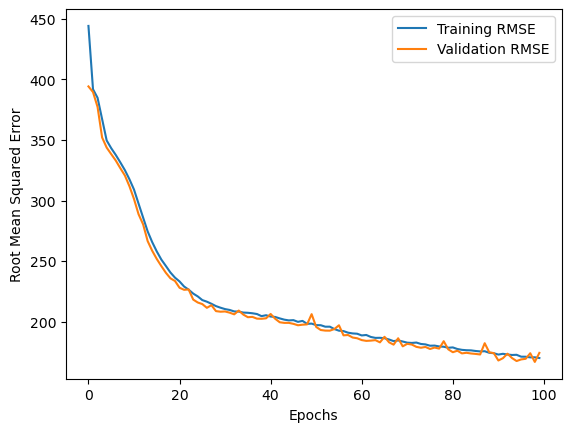

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation RMSE
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()


In [55]:
import numpy as np
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set a random seed for reproducibility
np.random.seed(42)

# Define the model creation function
def create_model(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Set up early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=True)

# Wrap the model with KerasRegressor
model = KerasRegressor(
    model=create_model,
    verbose=0,
    callbacks=[early_stopping]
)

# Define a smaller parameter grid for faster tuning
param_grid = {
    'model__optimizer': ['adam'],  # Focus on one optimizer
    'model__dropout_rate': [0.0, 0.2],  # Fewer options
    'batch_size': [64],  # Use a single batch size
    'epochs': [50],  # Fewer epochs for grid search
}

# Set up GridSearchCV with parallel processing
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search
grid_result = grid.fit(X_train, y_train)

# Output the best hyperparameters
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", -grid_result.best_score_)

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
test_loss, test_mae = best_model.score(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


2024-12-03 20:14:53.236769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 20:14:53.237331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 20:14:53.237038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 20:14:53.237123: I tensorflow/core/platform/cpu_featu

Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__optimizer': 'adam'}
Best Score: 169.05650604394378


TypeError: cannot unpack non-iterable float object

In [57]:
# Evaluate the best model on the test set
test_loss, test_mae = best_model.model_.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Test Loss: 87562.6250, Test MAE: 223.9816


In [58]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict using the best model
y_pred = best_model.predict(X_test)

# Compute evaluation metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
test_r2 = r2_score(y_test, y_pred)  # R²

# Since best_model.score only returns a single score, use it for MAE
test_mae = -best_model.score(X_test, y_test)  # Convert negative MAE back to positive

# Print the metrics
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")



Test MAE: -0.4407
Test RMSE: 295.9098
Test R²: 0.4407
